In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import itertools

%matplotlib inline

## Zadanie 3.
a) Sprawdź działanie zaimplementowanej w notebooku strategii ewolucyjnej dla
zmodyfikowanych funkcji sferycznych.

b) Sprawdź czy zmiana modelu mutacji w zaimplementowanej strategii ewolucyjnej zmieni skuteczność algorytmu. Rozważ przykładowe modele mutacji pokazane w notebooku i inne własne pomysły.

In [2]:
# Sphere function (minimum at 0)
def F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def F2(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def F3(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def F4(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])

In [3]:
def es(mutation_func, objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, verbose=False):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
            
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas *= np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions += mutation_func(children_population_sigmas, number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]
        
        if verbose:
            if np.mod(t, log_frequency) == 0:
                print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [4]:
def mut_func1(sigmas, N, d):
    return sigmas * np.random.randn(N, d)

def mut_func2(sigmas, N, d):
    sigma = np.cov(sigmas.T)
    return np.dot(np.random.randn(N, d), np.linalg.cholesky(sigma).T)



F1
Best ind: 0.0


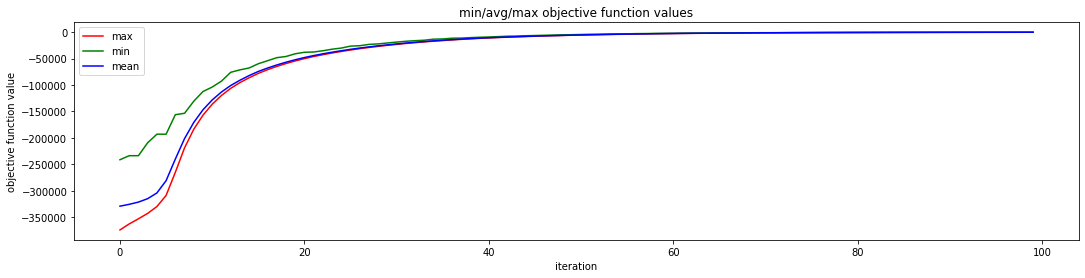

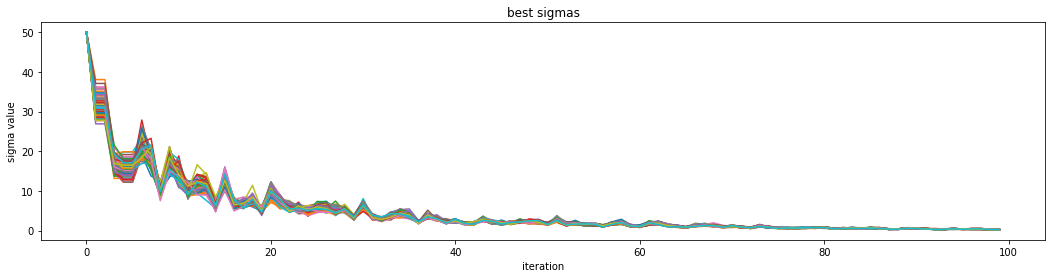



F2
Best ind: 0.0


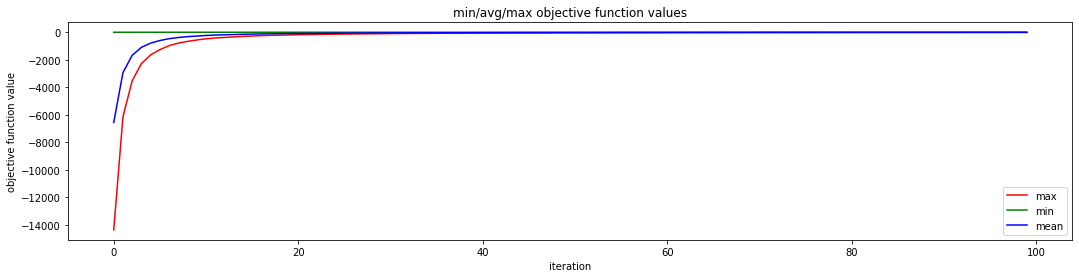

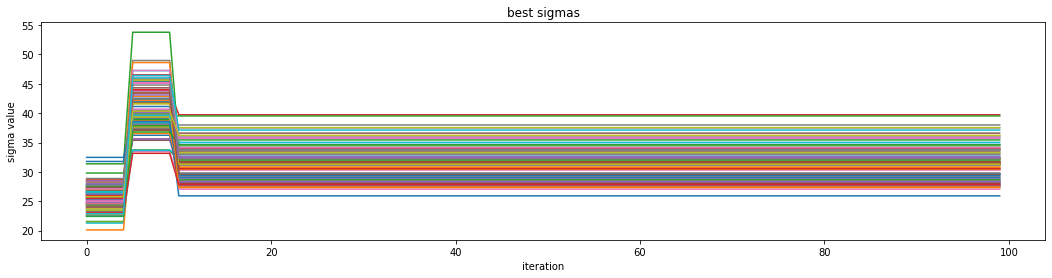



F3
Best ind: 0.0


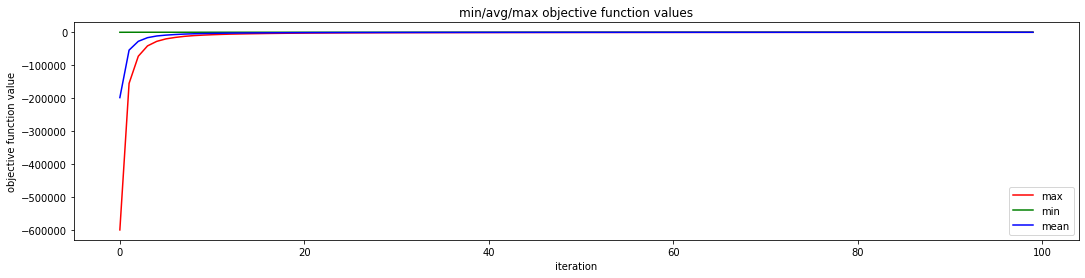

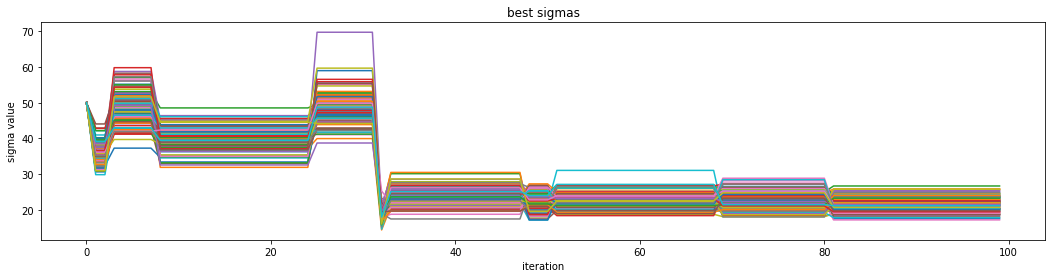



F4
Best ind: 0.0


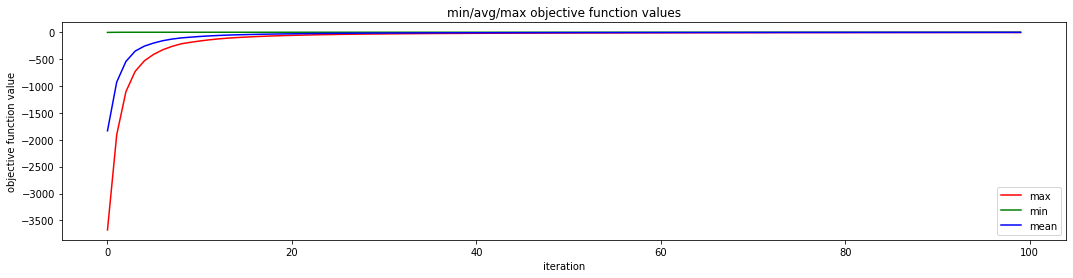

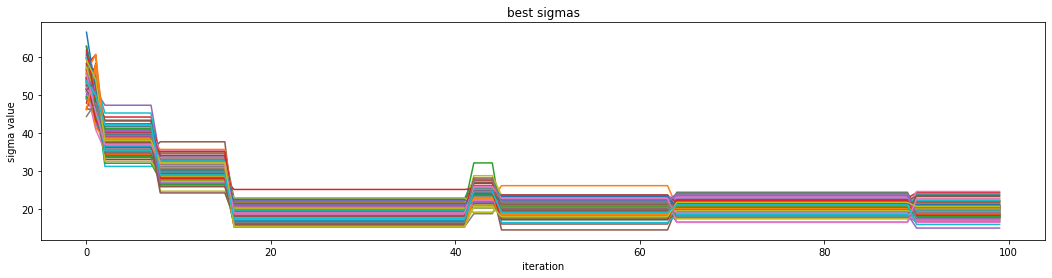

In [5]:
d = 100
K = 1
N = 2000
T = 100

for i, F in enumerate([F1, F2, F3, F4]):
    print(f'\n\nF{i+1}')
    tau, tau0 = 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d))

    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(mut_func1,
        F, d, N, T, 2*N, 2, 50.0, tau, tau0, log_frequency=10)
    print(f'Best ind: {best_objective_value}')

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0], 'r', label='max')
    plt.plot(history_objective_values[:, 1], 'g', label='min')
    plt.plot(history_objective_values[:, 2], 'b', label='mean')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.legend()
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas)
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()



F1
Best ind: 0.0


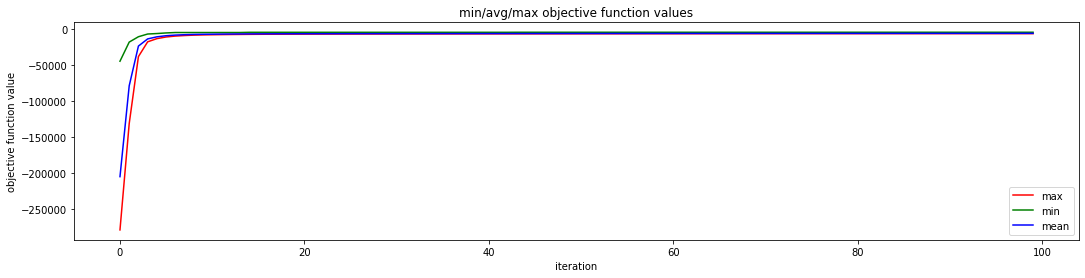

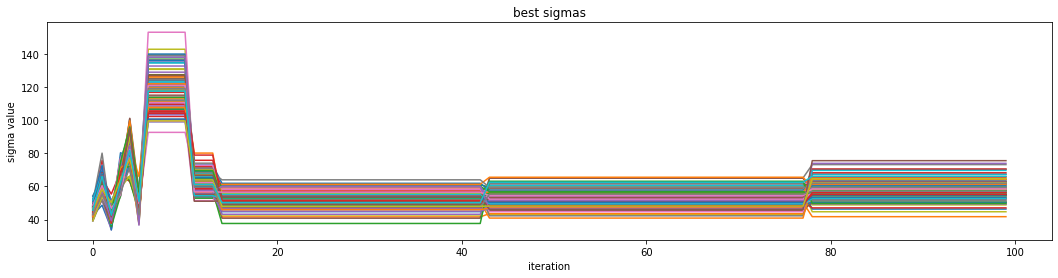



F2
Best ind: 0.0


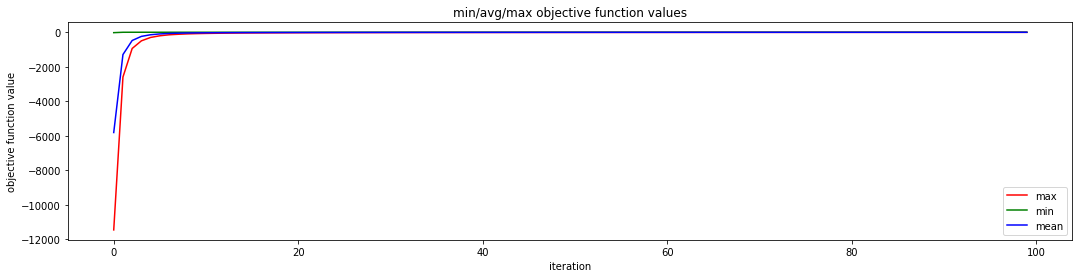

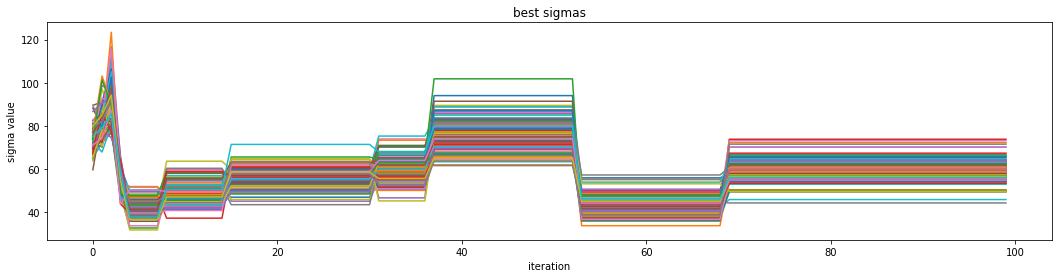



F3
Best ind: 0.0


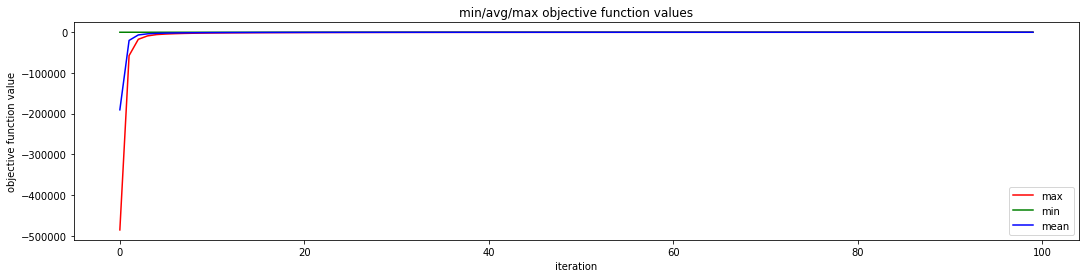

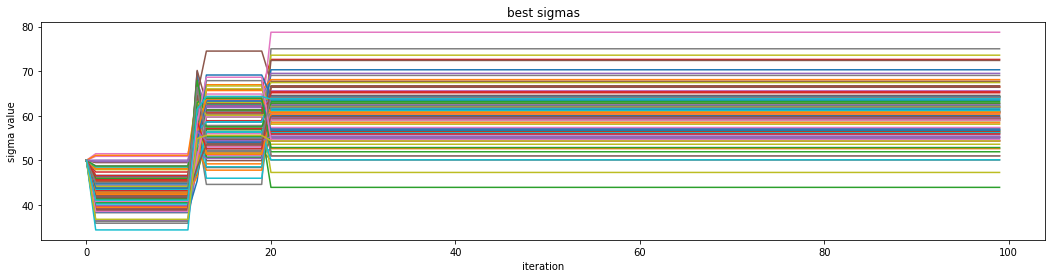



F4
Best ind: 0.0


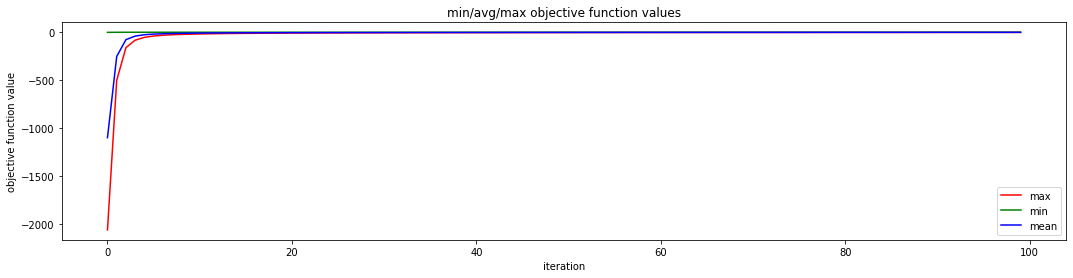

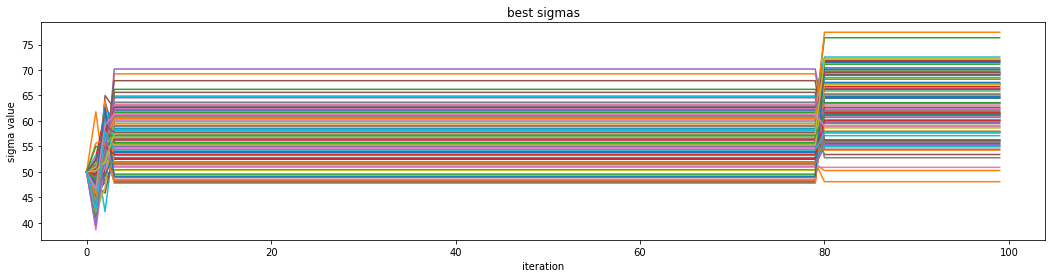

In [6]:
d = 100
K = 1
N = 2000
T = 100

for i, F in enumerate([F1, F2, F3, F4]):
    print(f'\n\nF{i+1}')
    tau, tau0 = 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d))

    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(mut_func2,
        F, d, N, T, 2*N, 2, 50.0, tau, tau0, log_frequency=10)
    print(f'Best ind: {best_objective_value}')

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0], 'r', label='max')
    plt.plot(history_objective_values[:, 1], 'g', label='min')
    plt.plot(history_objective_values[:, 2], 'b', label='mean')
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.legend()
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas)
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()